# Model for Toulouse

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None


    # OLS
import statsmodels.api as sm
    # ML Models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

    # Pipeline & Preprocess
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

    # Scores
from sklearn.metrics import balanced_accuracy_score, make_scorer, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error , r2_score
from sklearn.metrics import mean_absolute_percentage_error

#### Run Helpers

In [62]:
%run '../Helpers/Data_Process.py'
%run '../Helpers/Models.py'
%run '../Helpers/Data_visualisation.py'

#### Datasets

In [3]:
df = pd.read_csv('../Data/df_Toulouse_appartement_vf.csv',low_memory=False)

In [4]:
dfm = pd.read_csv('../Data/df_Toulouse_maison_vf.csv',low_memory=False)

In [5]:
list_dist_metro_dummies = []
for i in range(0,df.shape[0]):
    if df['dist_metro'].iloc[i] <= 200 :
        a = 0
    elif (df['dist_metro'].iloc[i] <= 500) & (df['dist_metro'].iloc[i] > 200) :
        a = 1
    elif (df['dist_metro'].iloc[i] > 500) & (df['dist_metro'].iloc[i] <= 1000) :
        a = 2
    else:
        a = 3
    list_dist_metro_dummies.append(a)
df['dist_metro_dummies'] = list_dist_metro_dummies

In [6]:
dummies_pr_var_continues(df, 'Nombre_dependance', 0)
dummies_pr_var_continues(df, 'Ec_maternelle', 0)
dummies_pr_var_continues(df, 'Ec_elementaire', 0)

### OLS (Price Index)

In [7]:
    # SPLIT test/train
df_train = df[df['date_mutation'] < '2021-04-01']
df_test = df[df['date_mutation'] >= '2021-04-01']

In [8]:
df_train = pd.concat([df_train, pd.get_dummies(df_train[['quarter']])], axis = 1)

In [9]:
    # Definition of a standard apartment
df_train['n_pieces_BienStandard'] = df_train['nombre_pieces_principales']-3
df_train['n_dependances_BienStandard'] = df_train['Nombre_dependance']

In [10]:
features_ols = ['quarter_2017_Q4', 'quarter_2018_Q1', 'quarter_2018_Q2', 'quarter_2018_Q3',
'quarter_2018_Q4', 'quarter_2019_Q1', 'quarter_2019_Q2',
'quarter_2019_Q3', 'quarter_2019_Q4', 'quarter_2020_Q1','quarter_2020_Q2', 
'quarter_2020_Q3', 'quarter_2020_Q4','quarter_2021_Q1',
'n_pieces_BienStandard', 'n_dependances_BienStandard']
outcome = 'Prix_m2'

In [11]:
model = model_OLS_prix(df_train, 'Prix_m2', features_ols, summary = True)

                            OLS Regression Results                            
Dep. Variable:                Prix_m2   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     142.4
Date:                Tue, 04 Apr 2023   Prob (F-statistic):               0.00
Time:                        10:36:49   Log-Likelihood:            -1.6238e+05
No. Observations:               19709   AIC:                         3.248e+05
Df Residuals:                   19692   BIC:                         3.249e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

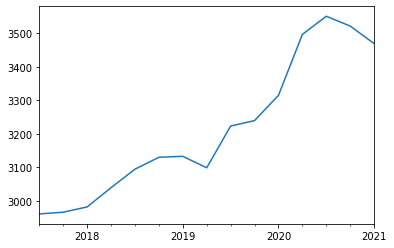

In [12]:
df_train = add_indice_prix(df_train, indice_prix_quarter(model, plot = True))

### KNN

In [13]:
    # Dependant variables : cooridnates
features_knn = ['latitude', 'longitude']
    # Output
label_train = 'Prix_m2_actualise_Q1_2021'
label_test = 'Prix_m2'

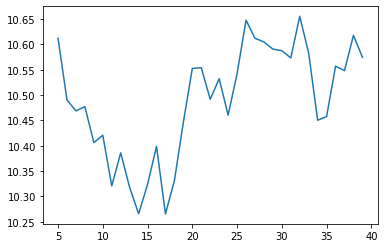

In [24]:
X_train_knn = df_train[features_knn]
X_test_knn = df_test[features_knn]
        # outcomes
y_train = df_train[label_train]
y_test = df_test[label_test]
knn = []
mdape = []
for i in np.arange(5, 40) :
    knn_model = KNeighborsRegressor(n_neighbors=i, weights='uniform')
    knn_model.fit(X_train_knn, y_train)
    knn.append(i)
    mdape_i = MDAPE(knn_model.predict(df_test[features_knn]), df_test[label_test])
    mdape.append(mdape_i)
plt.plot(knn, mdape)
plt.show()

In [28]:
knn_pipe = model_KNN_coordinates(df_train, df_test, features_knn,
                          label_train, label_test,
                          MinMaxScaler(), 'uniform', 20, 5)

Returned hyperparameter: {'Knn__n_neighbors': 17}


In [29]:
    # Scores on TRAIN dataset
compute_scores(knn_pipe, df_train[features_knn], df_train[label_train])

MAPE:  11.292270270798438
MDAPE:  8.877613566559612


In [30]:
    # Scores on TEST dataset
compute_scores(knn_pipe, df_test[features_knn], df_test[label_test])

MAPE:  11.978142371955926
MDAPE:  10.130742176956806


#### Analysis of mdape

In [53]:
X_test = df_test.copy()
    # Add predictions to the test sample
y_pred = knn_pipe.predict(X_test[features_knn])
X_test["y_pred"] = y_pred
    # Add the true value of the outcome in the test sample
X_test['y_true'] = df_test[label_test]
    # Compute the relative percentage error
X_test['mdape'] = np.abs((X_test['y_true'] - X_test["y_pred"])/X_test['y_true'])*100

In [55]:
round(X_test.groupby('quarter').agg({'mdape' : 'median'}).reset_index().set_index('quarter').T, 3)

quarter,2021_Q2,2021_Q3,2021_Q4,2022_Q1,2022_Q2
mdape,10.104,9.721,10.736,9.337,10.68


## Selection of features

In [33]:
df_test_vif = df[['nombre_pieces_principales','Nombre_dependance',
                  'N_apparts', 'Part_chomeurs', 'Ec_maternelle', 'Ec_elementaire',
                  'dist_metro', 'DISP_MED19']]

In [34]:
calc_vif(df_test_vif)

,variables,VIF
0,nombre_pieces_principales,7.092289
1,Nombre_dependance,2.999334
2,N_apparts,6.636223
3,Part_chomeurs,9.915903
4,Ec_maternelle,3.671775
5,Ec_elementaire,4.860537
6,dist_metro,2.819461
7,DISP_MED19,9.900096


### RF

In [36]:
features_RF = [#'Nombre_dependance', 
               'Nombre_dependance', 'dist_metro',
               #'dist_metro', 
               'nombre_pieces_principales',
               #'Ec_elementaire', 'Ec_maternelle',
               'Ec_elementaire', 'Ec_maternelle',
               'N_apparts', 
               'DISP_MED19', 
               'Part_chomeurs', 'DISP_MED19'
               #'P19_LOG','P19_RP_SDB','P19_RP_CCCOLL',
               #'P19_RP_CCIND','P19_RP_CINDELEC'
]

In [45]:
RF_model = model_RF_post_KNN(df_test, df_train, features_RF, features_knn, label_train, label_test,
                      model_knn = knn_pipe, standardisation = StandardScaler(), range_depth = [20, 40, 60], nb_cv = 5)

In [46]:
X_train_rf = df_train[features_RF]
X_train_rf['y_pred_knn'] = knn_pipe.predict(df_train[features_knn])
X_test_rf = df_test[features_RF]
X_test_rf['y_pred_knn'] = knn_pipe.predict(df_test[features_knn])
compute_scores(RF_model, X_test_rf, df_test[label_test])

MAPE:  11.755631312076297
MDAPE:  9.836899713608807


In [47]:
RF_model.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('RForest', RandomForestRegressor(max_depth=40))])

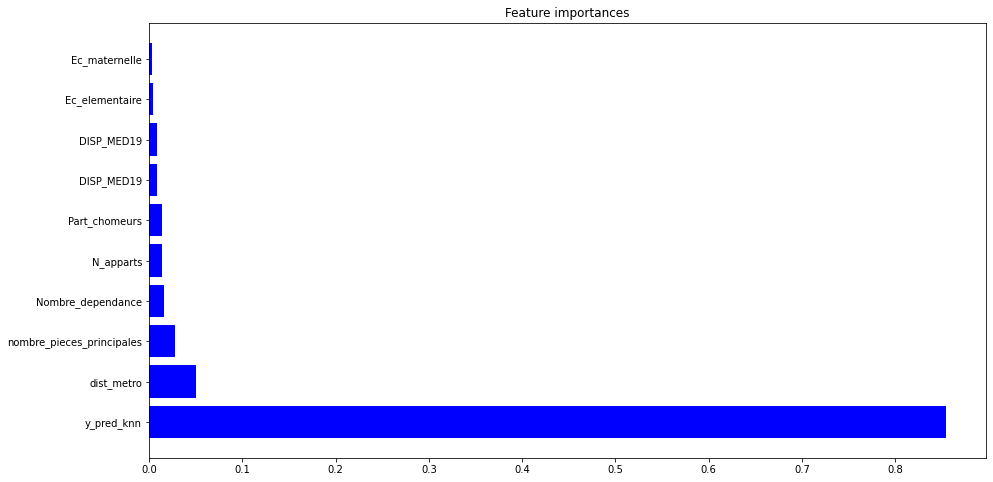

In [48]:
RF_importances = RF_model.best_estimator_.named_steps["RForest"].feature_importances_
features_importances(RF_importances, X_train_rf)

In [49]:
pipe = Pipeline([('scaler', StandardScaler()), ('GBoost', GradientBoostingRegressor())])
parameters = {'GBoost__n_estimators': [50, 100, 150, 250, 500]} # defining parameter space
gboost_pipe = GridSearchCV(pipe, parameters, cv=5)
gboost_pipe.fit(X_train_rf, df_train[label_train])

compute_scores(gboost_pipe, X_test_rf, df_test[label_test])

MAPE:  11.686250857270192
MDAPE:  9.901366567606484


#### Analysis of mdape

In [50]:
X_test = df_test.copy()
X_test['y_pred_knn'] = knn_pipe.predict(X_test[features_knn])

In [51]:
y_pred = RF_model.predict(X_test[features_RF + ['y_pred_knn']])
X_test["y_pred"] = y_pred
X_test['y_true'] = df_test[label_test]
X_test['mdape'] = np.abs((X_test['y_true'] - X_test["y_pred"])/X_test['y_true'])*100

In [52]:
X_test.groupby('quarter').agg({'mdape' : 'median'}).reset_index().set_index('quarter').T

quarter,2021_Q2,2021_Q3,2021_Q4,2022_Q1,2022_Q2
mdape,9.569807,9.999017,9.676679,9.537138,10.970013


## Maison

#### OLS

In [66]:
#dummies_pr_var_continues(dfm, 'dist_metro', 0.01)
dummies_pr_var_continues(dfm, 'Nombre_dependance', 0)
dummies_pr_var_continues(dfm, 'Ec_maternelle', 0)
dummies_pr_var_continues(dfm, 'Ec_elementaire', 0)

list_dist_metro_dummies = []
for i in range(0,dfm.shape[0]):
    if dfm['dist_metro'].iloc[i] <= 200 :
        a = 0
    elif (dfm['dist_metro'].iloc[i] <= 500) & (dfm['dist_metro'].iloc[i] > 200) :
        a = 1
    elif (dfm['dist_metro'].iloc[i] > 500) & (dfm['dist_metro'].iloc[i] <= 1000) :
        a = 2
    else:
        a = 3
    list_dist_metro_dummies.append(a)
dfm['dist_metro_dummies'] = list_dist_metro_dummies

In [67]:
print(dfm.surface_reelle_bati.mean())
print(dfm.surface_terrain.mean())

110.43460898502497
292.9850249584027


In [68]:
df_train_m = dfm[dfm['date_mutation'] < '2021-04-01']
df_test_m = dfm[dfm['date_mutation'] >= '2021-04-01']

df_train_m = pd.concat([df_train_m, pd.get_dummies(df_train_m[['quarter']])], axis = 1)
df_train_m['n_pieces_BienStandard'] = df_train_m['nombre_pieces_principales']- 4 #4c'est le nombre le plus frequent
df_train_m['n_dependances_BienStandard'] = df_train_m['Nombre_dependance']
df_train_m['surf_bati_BienStandard'] = df_train_m['surface_reelle_bati'] - dfm.surface_reelle_bati.mean()
df_train_m['surf_terrain_BienStandard'] = df_train_m['surface_terrain'] - dfm.surface_terrain.mean()


features_ols = ['quarter_2017_Q4', 'quarter_2018_Q1', 'quarter_2018_Q2', 'quarter_2018_Q3',
'quarter_2018_Q4', 'quarter_2019_Q1', 'quarter_2019_Q2',
'quarter_2019_Q3', 'quarter_2019_Q4', 'quarter_2020_Q1','quarter_2020_Q2', 
'quarter_2020_Q3', 'quarter_2020_Q4','quarter_2021_Q1',
'n_pieces_BienStandard', 'n_dependances_BienStandard', 'surf_bati_BienStandard', 'surf_terrain_BienStandard']
outcome = 'valeur_fonciere'

In [69]:
model_m = model_OLS_prix(df_train_m, 'valeur_fonciere', features_ols, summary = True)

                            OLS Regression Results                            
Dep. Variable:        valeur_fonciere   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     348.9
Date:                Tue, 04 Apr 2023   Prob (F-statistic):               0.00
Time:                        10:58:38   Log-Likelihood:                -30350.
No. Observations:                2336   AIC:                         6.074e+04
Df Residuals:                    2317   BIC:                         6.085e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

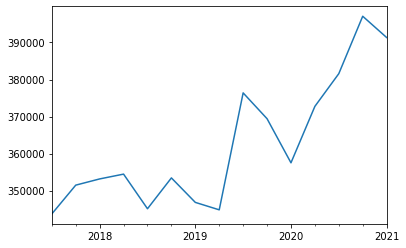

In [70]:
df_train_m = add_indice_prix_house(df_train_m, indice_prix_quarter(model_m, plot = True))

### KNN

In [95]:
    # Dependant variables : cooridnates
features_knn = ['latitude', 'longitude']
    # Output
label_train_m  = 'val_fonciere_actualise_Q1_2021'
label_test_m   = 'valeur_fonciere'

knn_pipe_m = model_KNN_coordinates(df_train_m, df_test_m, features_knn,
                          label_train_m, label_test_m,
                          MinMaxScaler(), 'uniform', 25, 5)

Returned hyperparameter: {'Knn__n_neighbors': 15}


In [96]:
    # Scores on TRAIN dataset
compute_scores(knn_pipe_m, df_train_m[features_knn], df_train_m[label_train_m])

MAPE:  28.215799434086808
MDAPE:  18.911931870240352


In [97]:
    # Scores on TEST dataset
compute_scores(knn_pipe_m, df_test_m[features_knn], df_test_m[label_test_m])

MAPE:  27.761174502155363
MDAPE:  20.42674512322995


### Selection of features

In [87]:
df_test_vif = df[['Nombre_dependance', 'N_maisons',
                  'Part_chomeurs', 'Ec_maternelle', 'Ec_elementaire',
                  'dist_metro', 'surface_reelle_bati', 'surface_terrain']]

In [88]:
calc_vif(df_test_vif)

,variables,VIF
0,Nombre_dependance,3.148067
1,N_maisons,3.906678
2,Part_chomeurs,6.660674
3,Ec_maternelle,3.562585
4,Ec_elementaire,4.263427
5,dist_metro,3.363504
6,surface_reelle_bati,5.091317
7,surface_terrain,1.010927


### RF

In [108]:
features_RF_m = [#'Nombre_dependance_dummy',
                 'N_maisons',
                  'Part_chomeurs', 
                 #'Ec_maternelle_dummy', 'Ec_elementaire_dummy',
                  'dist_metro', 'surface_reelle_bati', 'surface_terrain']

In [109]:
RF_model_m = model_RF_post_KNN(df_test_m, df_train_m, features_RF_m, features_knn, 
                               label_train_m, label_test_m,
                               model_knn = knn_pipe_m, standardisation = StandardScaler(), 
                               range_depth = [20, 40, 60], nb_cv = 5)


In [110]:
X_train_rf_m = df_train_m[features_RF_m]
X_train_rf_m['y_pred_knn'] = knn_pipe_m.predict(df_train_m[features_knn])
X_test_rf_m = df_test_m[features_RF_m]
X_test_rf_m['y_pred_knn'] = knn_pipe_m.predict(df_test_m[features_knn])
compute_scores(RF_model_m, X_test_rf_m, df_test_m[label_test_m])

MAPE:  13.549182797807283
MDAPE:  10.385069260478849


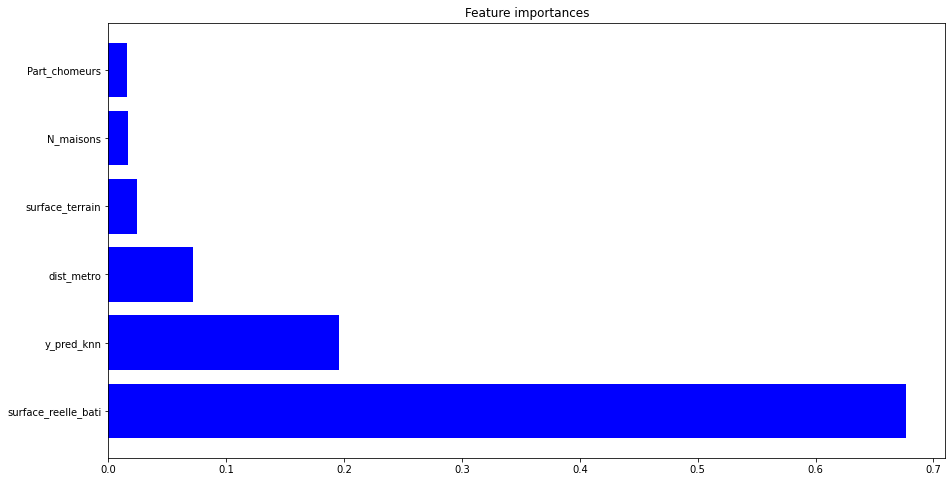

In [111]:
RF_importances_m = RF_model_m.best_estimator_.named_steps["RForest"].feature_importances_
features_importances(RF_importances_m, X_train_rf_m)

In [112]:
X_test = df_test.copy()
X_test['y_pred_knn'] = knn_pipe.predict(X_test[features_knn])
y_pred = RF_model.predict(X_test[features_RF + ['y_pred_knn']])
X_test["y_pred"] = y_pred
X_test['y_true'] = df_test[label_test]
X_test['mdape'] = np.abs((X_test['y_true'] - X_test["y_pred"])/X_test['y_true'])*100

In [127]:
X_test['quantile_surf'] = pd.qcut(X_test['surface_reelle_bati'], 6, labels=False)
#X_test['quantile_terrain'] = pd.qcut(X_test['surface_terrain'], 7, labels=False)
X_test['quantile_valfonciere'] = pd.qcut(X_test['valeur_fonciere'], 6, labels=False)

In [123]:
X_test.groupby('quantile_surf').agg({'mdape' : 'median'}).reset_index().set_index('quantile_surf').T

quantile_surf,0,1,2,3,4,5
mdape,11.458765,9.768001,9.471492,9.494436,9.200924,9.736483


In [128]:
X_test.groupby('quantile_valfonciere').agg({'mdape' : 'median'}).reset_index().set_index('quantile_valfonciere').T

quantile_valfonciere,0,1,2,3,4,5
mdape,9.86857,9.986994,8.833322,9.47825,9.67377,11.371809


### GradientBoost

In [103]:
pipe = Pipeline([('scaler', StandardScaler()), ('GBoost', GradientBoostingRegressor())])
parameters = {'GBoost__n_estimators': [50, 100, 150, 250, 500]} # defining parameter space
gboost_pipe = GridSearchCV(pipe, parameters, cv=5)
gboost_pipe.fit(X_train_rf_m, df_train_m[label_train_m])

compute_scores(gboost_pipe, X_test_rf_m, df_test_m[label_test_m])

MAPE:  13.913051410328443
MDAPE:  10.969994680872164
